> [Detrended Fluctuation Analysis in the prediction of type 2 diabetes mellitus in patients at risk: Model optimization and comparison with other metrics](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0225817)


# 1. Preliminary Analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import glob
import os
import re
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

## 1.1 Clinical Data

**Clininal Data Overview:**

* *pid patient id*
* *gender (0 = male, 1 = female)*
* *age (years)*
* *body mass index (Kg/m2)*
* *basal glycaemia (mg/dL)*
* *HbA1c (%)*
* *follow-up (days)*
* *final diagnosis of type 2 diabetes mellitus*

In [2]:
# Load clinical data
clinical_path = './S1/clinical_data.txt'
cols = ["pid", "gender", "age", "BMI", "glycaemia", "HbA1c", "follow.up", "T2DM"]
clinical_df = pd.read_csv(clinical_path,sep=r'\s+',engine='python',header=None,quotechar='"',skiprows=1,names=cols)
clinical_df["pid"] = clinical_df["pid"].astype(str).str.replace('"', '').astype(int)
print("\n")
print("="*100)
print(f"Clinical_data.txt imported.")

# Load each patients data
s1_folder_path = './S1'
case_csv_files = glob.glob(os.path.join(s1_folder_path, 'case*.csv'))
cnt = 0
for file_path in case_csv_files:
  # print(file_path)
  cnt += 1
print(f'Total {cnt} Patient files Loaded.')



Clinical_data.txt imported.
Total 208 Patient files Loaded.


In [3]:
# checking missing values in clinical_df
clinical_tmp = clinical_df.copy()
for col in clinical_tmp.columns:
    if clinical_tmp[col].dtype == object:
        clinical_tmp[col] = clinical_tmp[col].replace({"NA": np.nan, "na": np.nan, "Na": np.nan, "": np.nan}).where(
            clinical_tmp[col].astype(str).str.strip().ne(""), np.nan
        )

total_rows = len(clinical_tmp)
missing_count = clinical_tmp.isna().sum().rename("missing_count")
missing_pct = ((missing_count / total_rows) * 100).round(2).rename("missing_pct")
non_missing_count = (total_rows - missing_count).rename("non_missing_count")
dtypes = clinical_df.dtypes.astype(str).rename("dtype")

missing_stats = pd.concat([missing_count, missing_pct, non_missing_count, dtypes], axis=1)
print(f"Total rows: {total_rows}")
print("Missing values in clinical_df:")
display(missing_stats)

Total rows: 208
Missing values in clinical_df:


,missing_count,missing_pct,non_missing_count,dtype
pid,0,0.00,208,int64
gender,0,0.00,208,int64
age,0,0.00,208,int64
BMI,1,0.48,207,float64
glycaemia,0,0.00,208,int64
HbA1c,8,3.85,200,float64
follow.up,12,5.77,196,float64
T2DM,0,0.00,208,bool


In [4]:
clinical_df.describe()

,pid,gender,age,BMI,glycaemia,HbA1c,follow.up
count,208.000000,208.000000,208.000000,207.000000,208.000000,200.000000,196.000000
mean,105.125000,0.504808,59.600962,29.993237,100.581731,5.763500,979.831633
std,60.596103,0.501183,10.094692,4.738661,11.407814,0.295558,371.916226
min,1.000000,0.000000,29.000000,18.100000,78.000000,5.100000,176.000000
25%,52.750000,0.000000,54.000000,27.000000,92.000000,5.600000,678.500000
50%,105.500000,1.000000,61.000000,29.300000,101.000000,5.800000,992.500000
75%,157.250000,1.000000,66.000000,32.400000,108.000000,6.000000,1254.250000
max,209.000000,1.000000,88.000000,48.700000,135.000000,6.500000,2211.000000


## 1.2 Individual Patient Data

**Goal**
* Mean glucose  For each patient and for the whole dataset.
* Median glucose For each patient and for the whole dataset.
* Standard deviation:  For each patient and for the whole dataset.
* Minimum glucose: For each patient and for the whole dataset.
* Maximum glucose: For each patient and for the whole dataset.
* Range = max – min :For each patient and for the whole dataset.
* Coefficient of variation (CV) = SD / Mean : For each patient and for the whole dataset.
* percentage of readings <70 mg/dL  only for each patient.
* Percentage of readings between 70–170 mg/dL  only for each patient
* Percentage  of readings >170 mg/dL  only for each patient.


In [5]:
# Compute the Overall descriptive statistics for the 'glucemia' column across all loaded DataFrames.
all_glucemia_data = pd.concat([pd.read_csv(file_path)['glucemia'] for file_path in case_csv_files])

overall_mean_glucose = all_glucemia_data.mean()
overall_median_glucose = all_glucemia_data.median()
overall_std_glucose = all_glucemia_data.std()
overall_min_glucose = all_glucemia_data.min()
overall_max_glucose = all_glucemia_data.max()
overall_range_glucose = overall_max_glucose - overall_min_glucose
overall_cv_glucose = (overall_std_glucose / overall_mean_glucose) if overall_mean_glucose != 0 else np.nan

overall_stats = {
    'mean': overall_mean_glucose,
    'median': overall_median_glucose,
    'std': overall_std_glucose,
    'min': overall_min_glucose,
    'max': overall_max_glucose,
    'range': overall_range_glucose,
    'cv': overall_cv_glucose,
}

In [6]:
# Calculated descriptive statistics for each patient and for the whole dataset.
case_stats_list = []

cnt = 0
for file_path in case_csv_files:
    cnt += 1
    df_case = pd.read_csv(file_path)
    glucemia_data = df_case['glucemia']

    mean_glucose = glucemia_data.mean()
    median_glucose = glucemia_data.median()
    std_glucose = glucemia_data.std()
    min_glucose = glucemia_data.min()
    max_glucose = glucemia_data.max()
    range_glucose = max_glucose - min_glucose
    cv_glucose = (std_glucose / mean_glucose) if mean_glucose != 0 else np.nan

    percent_lt_70 = (glucemia_data < 70).mean() * 100
    percent_70_170 = ((glucemia_data >= 70) & (glucemia_data <= 170)).mean() * 100
    percent_gt_170 = (glucemia_data > 170).mean() * 100

    case_stats = {
        'file_name': os.path.basename(file_path),
        'mean': mean_glucose,
        'median': median_glucose,
        'std': std_glucose,
        'min': min_glucose,
        'max': max_glucose,
        'range': range_glucose,
        'cv': cv_glucose,
        '% < 70': percent_lt_70,
        '% 70-170': percent_70_170,
        '% > 170': percent_gt_170,
    }
    case_stats_list.append(case_stats)

case_stats_df = pd.DataFrame(case_stats_list)
print(f"Total {cnt} Patient files Loaded.")

Total 208 Patient files Loaded.


In [7]:
# Display the calculated descriptive statistics for each patient and for the whole dataset.
print('\033[1m' + "\nOverall Descriptive Statistics for Glucose Levels:" + '\033[0m', "\n")
display(pd.DataFrame([overall_stats]))
print("-"*100,"\n")
print('\033[1m' +  "Descriptive Statistics for Each Patient:" + '\033[0m')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(case_stats_df.head())


Overall Descriptive Statistics for Glucose Levels: 



,mean,median,std,min,max,range,cv
0,102.320342,100.0,21.805964,40.0,318.0,278.0,0.213115


---------------------------------------------------------------------------------------------------- 

Descriptive Statistics for Each Patient:


,file_name,mean,median,std,min,max,range,cv,% < 70,% 70-170,% > 170
0,case 142.csv,115.355903,109.0,19.627932,86.0,170.0,84.0,0.170151,0.000000,100.000000,0.000000
1,case 156.csv,158.125000,153.0,31.629568,84.0,222.0,138.0,0.200029,0.000000,61.805556,38.194444
2,case 181.csv,97.206597,97.0,7.316261,81.0,116.0,35.0,0.075265,0.000000,100.000000,0.000000
3,case 195.csv,84.230903,87.0,13.160831,51.0,116.0,65.0,0.156247,13.888889,86.111111,0.000000
4,case 59.csv,112.491950,111.0,16.050643,84.0,164.0,80.0,0.142683,0.000000,97.048611,0.000000


# 2. Data Visualization

Generate plots to visualize the distribution of descriptive statistics across patients.

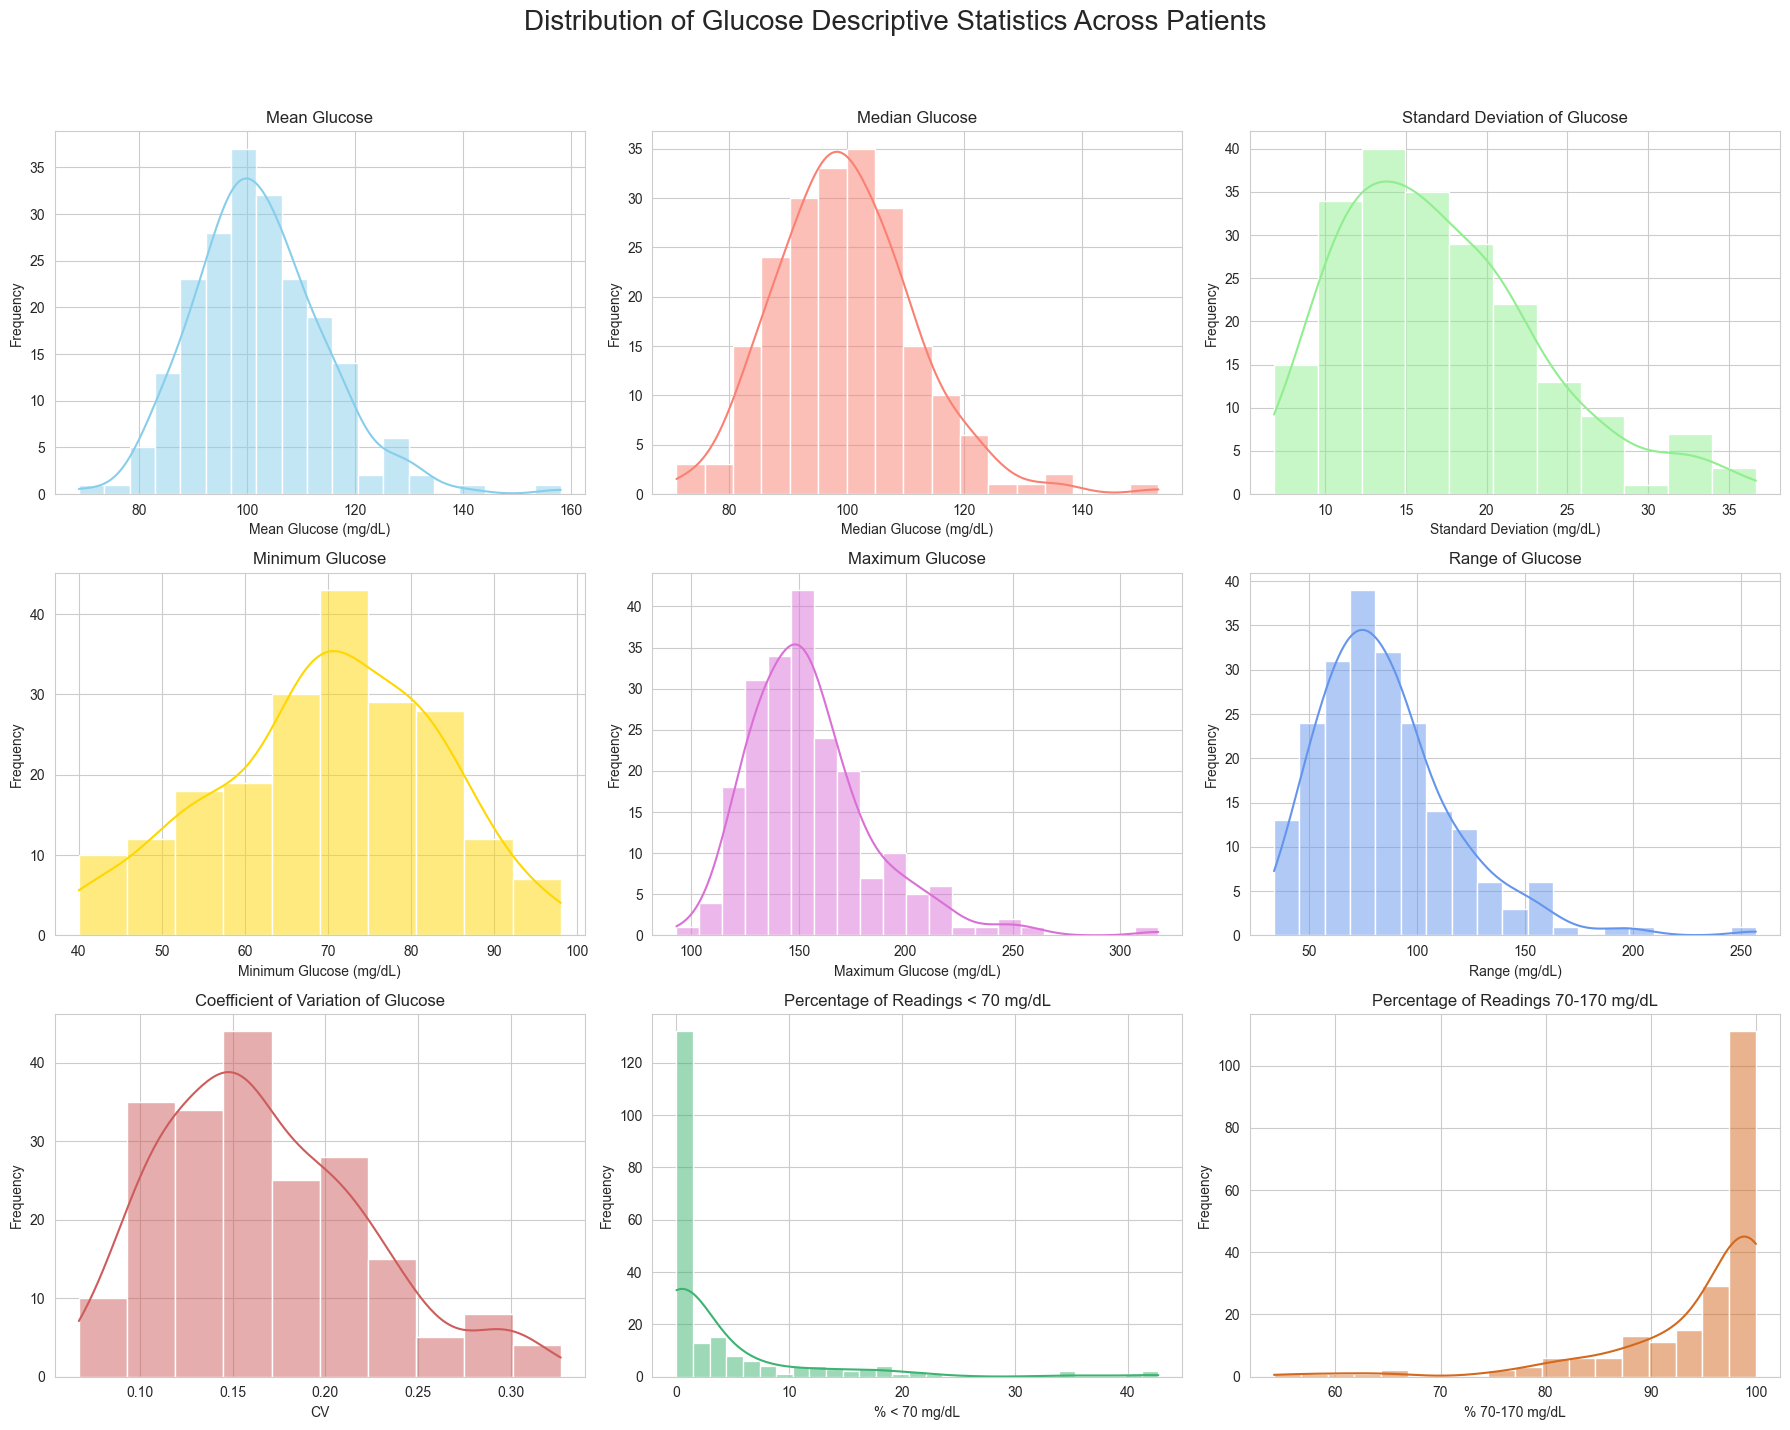

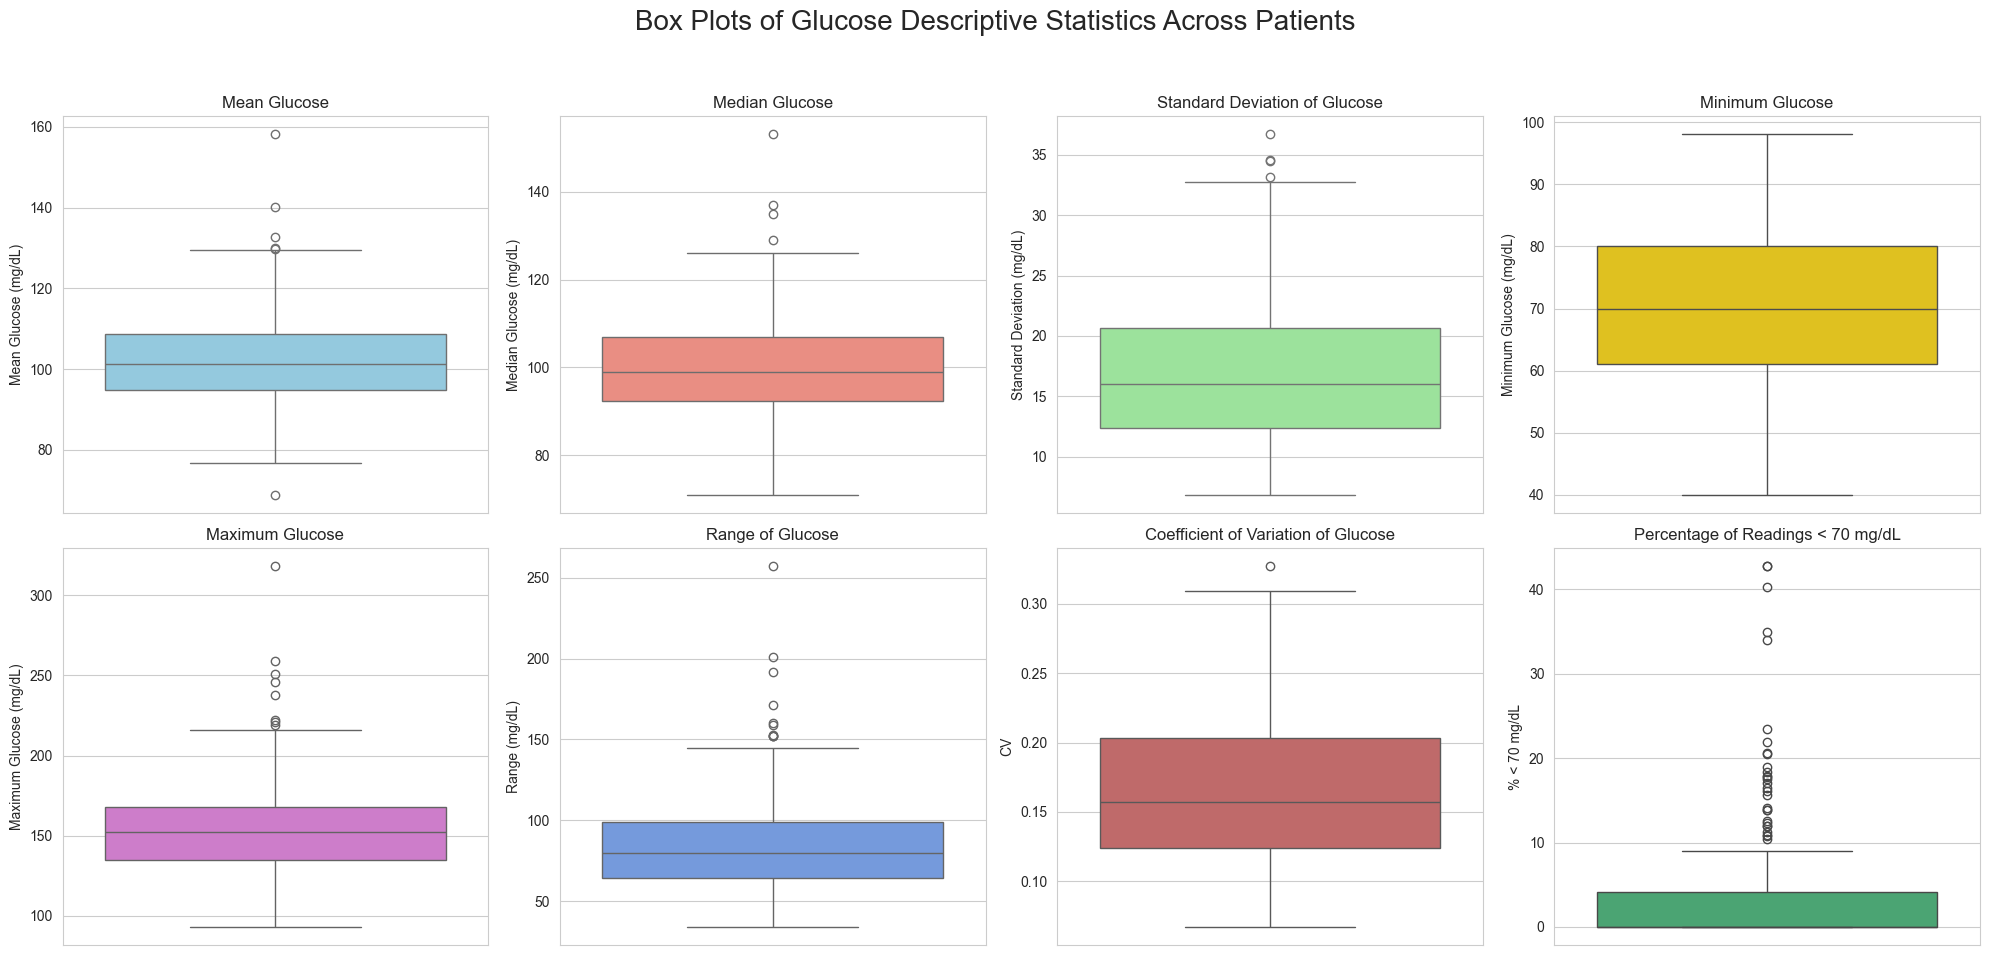

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Create histograms for key statistics
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
fig.suptitle('Distribution of Glucose Descriptive Statistics Across Patients', fontsize=20)

sns.histplot(case_stats_df['mean'], ax=axes[0, 0], kde=True, color='skyblue')
axes[0, 0].set_title('Mean Glucose')
axes[0, 0].set_xlabel('Mean Glucose (mg/dL)')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(case_stats_df['median'], ax=axes[0, 1], kde=True, color='salmon')
axes[0, 1].set_title('Median Glucose')
axes[0, 1].set_xlabel('Median Glucose (mg/dL)')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(case_stats_df['std'], ax=axes[0, 2], kde=True, color='lightgreen')
axes[0, 2].set_title('Standard Deviation of Glucose')
axes[0, 2].set_xlabel('Standard Deviation (mg/dL)')
axes[0, 2].set_ylabel('Frequency')

sns.histplot(case_stats_df['min'], ax=axes[1, 0], kde=True, color='gold')
axes[1, 0].set_title('Minimum Glucose')
axes[1, 0].set_xlabel('Minimum Glucose (mg/dL)')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(case_stats_df['max'], ax=axes[1, 1], kde=True, color='orchid')
axes[1, 1].set_title('Maximum Glucose')
axes[1, 1].set_xlabel('Maximum Glucose (mg/dL)')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(case_stats_df['range'], ax=axes[1, 2], kde=True, color='cornflowerblue')
axes[1, 2].set_title('Range of Glucose')
axes[1, 2].set_xlabel('Range (mg/dL)')
axes[1, 2].set_ylabel('Frequency')

sns.histplot(case_stats_df['cv'], ax=axes[2, 0], kde=True, color='indianred')
axes[2, 0].set_title('Coefficient of Variation of Glucose')
axes[2, 0].set_xlabel('CV')
axes[2, 0].set_ylabel('Frequency')

sns.histplot(case_stats_df['% < 70'], ax=axes[2, 1], kde=True, color='mediumseagreen')
axes[2, 1].set_title('Percentage of Readings < 70 mg/dL')
axes[2, 1].set_xlabel('% < 70 mg/dL')
axes[2, 1].set_ylabel('Frequency')

sns.histplot(case_stats_df['% 70-170'], ax=axes[2, 2], kde=True, color='chocolate')
axes[2, 2].set_title('Percentage of Readings 70-170 mg/dL')
axes[2, 2].set_xlabel('% 70-170 mg/dL')
axes[2, 2].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# You can also create box plots to see the distribution and outliers
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle('Box Plots of Glucose Descriptive Statistics Across Patients', fontsize=20)

sns.boxplot(y=case_stats_df['mean'], ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Mean Glucose')
axes[0, 0].set_ylabel('Mean Glucose (mg/dL)')

sns.boxplot(y=case_stats_df['median'], ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Median Glucose')
axes[0, 1].set_ylabel('Median Glucose (mg/dL)')

sns.boxplot(y=case_stats_df['std'], ax=axes[0, 2], color='lightgreen')
axes[0, 2].set_title('Standard Deviation of Glucose')
axes[0, 2].set_ylabel('Standard Deviation (mg/dL)')

sns.boxplot(y=case_stats_df['min'], ax=axes[0, 3], color='gold')
axes[0, 3].set_title('Minimum Glucose')
axes[0, 3].set_ylabel('Minimum Glucose (mg/dL)')

sns.boxplot(y=case_stats_df['max'], ax=axes[1, 0], color='orchid')
axes[1, 0].set_title('Maximum Glucose')
axes[1, 0].set_ylabel('Maximum Glucose (mg/dL)')

sns.boxplot(y=case_stats_df['range'], ax=axes[1, 1], color='cornflowerblue')
axes[1, 1].set_title('Range of Glucose')
axes[1, 1].set_ylabel('Range (mg/dL)')

sns.boxplot(y=case_stats_df['cv'], ax=axes[1, 2], color='indianred')
axes[1, 2].set_title('Coefficient of Variation of Glucose')
axes[1, 2].set_ylabel('CV')

sns.boxplot(y=case_stats_df['% < 70'], ax=axes[1, 3], color='mediumseagreen')
axes[1, 3].set_title('Percentage of Readings < 70 mg/dL')
axes[1, 3].set_ylabel('% < 70 mg/dL')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 2.1 Missing Values Check

In [9]:
# Check missing values in clinical data
clinical_missing_values = clinical_df.isnull().sum()
print("Missing values in clinical_df:")
print(clinical_missing_values)

# Check missing values in individual patient glucose data
case_glucemia_missing_values = {}
for file_path in case_csv_files:
    df_case = pd.read_csv(file_path)
    missing_count = df_case['glucemia'].isnull().sum()
    case_glucemia_missing_values[os.path.basename(file_path)] = missing_count

print("\nMissing values in 'glucemia' column for each patient file:")
for file_name, count in case_glucemia_missing_values.items():
    if count > 0:
        print(f"{file_name}: {count}")

Missing values in clinical_df:
pid           0
gender        0
age           0
BMI           1
glycaemia     0
HbA1c         8
follow.up    12
T2DM          0
dtype: int64

Missing values in 'glucemia' column for each patient file:
case  59.csv: 17
case  9.csv: 17
case  70.csv: 9
case  141.csv: 43
case  73.csv: 17
case  197.csv: 8
case  150.csv: 48
case  184.csv: 20
case  191.csv: 9
case  132.csv: 8
case  130.csv: 3
case  118.csv: 17
case  24.csv: 59
case  30.csv: 8
case  19.csv: 9
case  112.csv: 17
case  20.csv: 8
case  111.csv: 17
case  104.csv: 20
case  201.csv: 38
case  1.csv: 9
case  148.csv: 50
case  159.csv: 26
case  207.csv: 33
case  6.csv: 30
case  80.csv: 10
case  43.csv: 9
case  158.csv: 20
case  164.csv: 17
case  41.csv: 9
case  204.csv: 20
case  205.csv: 17
case  4.csv: 8
case  68.csv: 9


# 3. Preprocessing 
Preprocess raw data with missing values/records using two 2 approach


**Approach 1:**

- Make a copy of your current code and dataframe.
- Drop the case 79, 209, and all the patients whom HbA1c is missing.
- Take the max of "follow up" and use that value to impute the missing values.
- Fill the row where BMI is missing with :29.3. I got this value from their paper. 

**Approach 2:**

- Make a copy of your current code and dataframe.
- Drop the case 79, 209.
- Fill out and the rows with missing HbA1c with this value: 5.8, per their paper.
- Fill the missing "follow up" with 3 months (90 days).
- Fill the row where BMI is missing with this value:29.3, per their paper. 

## 3.1 Approach 1

In [10]:
# 1. CONFIGURATION
input_dir = "S1"
base_dir_a1 = "S1_approach1"   # new experiment folder
os.makedirs(base_dir_a1, exist_ok=True)

# define subdirectories under experiment folder
backup_dir = os.path.join(base_dir_a1, "S1_backup")
imputed_dir = os.path.join(base_dir_a1, "S1_perm")

# 2. BACKUP ORIGINAL DATA
if not os.path.exists(backup_dir):
    shutil.copytree(input_dir, backup_dir)
    print(f"Backup created: {backup_dir}")
else:
    print(f"Backup already exists: {backup_dir}")

# 3. DEFINE IMPUTATION FUNCTION
def impute_mean_of_neighbors(series):
    """Impute missing values using mean of previous two and next two non-NaN values."""
    s = pd.Series(series).copy()
    n = len(s)
    for i in range(n):
        if pd.isna(s.iloc[i]):
            prev_vals, next_vals = [], []

            # Look backward for up to 2 non-NaN values
            j = i - 1
            while j >= 0 and len(prev_vals) < 2:
                if not pd.isna(s.iloc[j]):
                    prev_vals.append(s.iloc[j])
                j -= 1

            # Look forward for up to 2 non-NaN values
            j = i + 1
            while j < n and len(next_vals) < 2:
                if not pd.isna(s.iloc[j]):
                    next_vals.append(s.iloc[j])
                j += 1

            neighbor_vals = prev_vals + next_vals
            if neighbor_vals:
                s.iloc[i] = np.mean(neighbor_vals)
    return s

# 4. IMPUTE CASE FILES
os.makedirs(imputed_dir, exist_ok=True)
case_paths = sorted(glob.glob(os.path.join(input_dir, "case*.csv")))
print(f"Found {len(case_paths)} case files in {input_dir}/")

for path in case_paths:
    df = pd.read_csv(path)
    if "glucemia" not in df.columns:
        print(f"Skipping {path} (no 'glucemia' column)")
        continue

    df["glucemia"] = pd.to_numeric(df["glucemia"], errors="coerce")
    imputed = impute_mean_of_neighbors(df["glucemia"])
    mask = df["glucemia"].isna()
    df.loc[mask, "glucemia"] = imputed[mask]

    base = os.path.basename(path)
    out_path = os.path.join(imputed_dir, base)
    df.to_csv(out_path, index=False, quoting=1)
    print(f" Imputed and wrote {out_path}")

# 5. LOAD & CLEAN CLINICAL DATA
clinical_columns = ["patient_id","gender","age","BMI","glycaemia","HbA1c","follow_up","T2DM"]
clinical_path_a1 = os.path.join(input_dir, "clinical_data.txt")

clinical_df_a1 = pd.read_csv(
    clinical_path_a1,
    sep=r"\s+",
    quotechar='"',
    engine="python",
    names=clinical_columns,
    skiprows=1,
)

# Clean patient_id (remove quotes etc.)
clinical_df_a1["patient_id"] = (
    clinical_df_a1["patient_id"]
    .astype(str)
    .str.strip()
    .str.replace('"', '', regex=False)
    .str.replace("'", '', regex=False)
    .astype(int)
)

# Clean numeric columns
for col in ["BMI", "HbA1c", "follow_up"]:
    clinical_df_a1[col] = (
        clinical_df_a1[col]
        .replace({"NA": np.nan, "na": np.nan, "Na": np.nan})
        .apply(lambda x: np.nan if (isinstance(x, str) and x.strip() == "") else x)
    )
    clinical_df_a1[col] = pd.to_numeric(clinical_df_a1[col], errors="coerce")

# Drop rules
clinical_df_a1 = clinical_df_a1[~clinical_df_a1["patient_id"].isin([79, 209])]
clinical_df_a1 = clinical_df_a1[clinical_df_a1["HbA1c"].notna()]

# Impute missing follow_up with max
if clinical_df_a1["follow_up"].notna().any():
    max_follow = clinical_df_a1["follow_up"].max()
    clinical_df_a1["follow_up"] = clinical_df_a1["follow_up"].fillna(max_follow)

# Fill missing BMI with 29.3
clinical_df_a1["BMI"] = clinical_df_a1["BMI"].fillna(29.3)

# Normalize T2DM column
if clinical_df_a1["T2DM"].dtype == object:
    clinical_df_a1["T2DM"] = (
        clinical_df_a1["T2DM"]
        .astype(str)
        .str.strip()
        .str.upper()
        .map({"TRUE": True, "FALSE": False})
    )

# Save cleaned clinical
cleaned_path_a1 = os.path.join(base_dir_a1, "clinical_data_cleaned_a1.txt")
clinical_df_a1.to_csv(cleaned_path_a1, sep=" ", index=False)
print(f"🧼 Cleaned clinical saved: {cleaned_path_a1}")

# 6. MERGE IMPUTED CASES WITH CLEANED CLINICAL
allowed_ids_a1 = set(clinical_df_a1["patient_id"].astype(int))
case_files_a1 = sorted(glob.glob(os.path.join(imputed_dir, "case*.csv")))

case_frames_a1 = []
for fp in case_files_a1:
    fn = os.path.basename(fp)
    m = re.search(r"(\d+)", fn)
    if not m:
        continue
    pid = int(m.group(1))
    if pid not in allowed_ids_a1:
        continue
    df_case = pd.read_csv(fp)
    df_case["patient_id"] = pid
    df_case["source_file"] = fn
    case_frames_a1.append(df_case)

cases_df_a1 = pd.concat(case_frames_a1, ignore_index=True) if case_frames_a1 else pd.DataFrame()

merged_df_a1 = cases_df_a1.merge(clinical_df_a1, on="patient_id", how="left")

# 7. FIX patient_id FIELD IF NEEDED
merged_df_a1["patient_id"] = (
    merged_df_a1["patient_id"]
    .astype(str)
    .str.extract(r"(\d+)")
    .astype(float)
    .astype("Int64")
)

# 8. SAVE MERGED DATA
merged_path_a1 = os.path.join(base_dir_a1, "merged_cases_with_clinical_a1_fixed.csv")
merged_df_a1.to_csv(merged_path_a1, index=False)
print(f"Final merged data saved: {merged_path_a1}")

# 9. SUMMARY
print(
    f"\nSummary:\n"
    f"  - Experiment folder: {base_dir_a1}\n"
    f"  - Patients kept: {len(allowed_ids_a1)}\n"
    f"  - Case rows: {len(cases_df_a1):,}\n"
    f"  - Merged rows: {len(merged_df_a1):,}\n"
)


Backup already exists: S1_approach1/S1_backup
Found 208 case files in S1/
 Imputed and wrote S1_approach1/S1_perm/case  1.csv
 Imputed and wrote S1_approach1/S1_perm/case  10.csv
 Imputed and wrote S1_approach1/S1_perm/case  100.csv
 Imputed and wrote S1_approach1/S1_perm/case  101.csv
 Imputed and wrote S1_approach1/S1_perm/case  102.csv
 Imputed and wrote S1_approach1/S1_perm/case  103.csv
 Imputed and wrote S1_approach1/S1_perm/case  104.csv
 Imputed and wrote S1_approach1/S1_perm/case  105.csv
 Imputed and wrote S1_approach1/S1_perm/case  106.csv
 Imputed and wrote S1_approach1/S1_perm/case  107.csv
 Imputed and wrote S1_approach1/S1_perm/case  108.csv
 Imputed and wrote S1_approach1/S1_perm/case  109.csv
 Imputed and wrote S1_approach1/S1_perm/case  11.csv
 Imputed and wrote S1_approach1/S1_perm/case  110.csv
 Imputed and wrote S1_approach1/S1_perm/case  111.csv
 Imputed and wrote S1_approach1/S1_perm/case  112.csv
 Imputed and wrote S1_approach1/S1_perm/case  113.csv
 Imputed and

## 3.2 Approach 2

In [11]:
# Setup new experiment folder
src_dir = "S1"
base_dir_a2 = "S1_approach2"

if os.path.exists(base_dir_a2):
    print(f"{base_dir_a2} already exists — skipping copy.")
else:
    shutil.copytree(src_dir, base_dir_a2)
    print(f"Copied {src_dir}/ → {base_dir_a2}/")

# Define helper for glucemia imputation
def impute_mean_of_neighbors(series):
    """Impute missing values using mean of previous two and next two non-NaN values."""
    s = series.copy()
    n = len(s)
    for i in range(n):
        if pd.isna(s[i]):
            prev_vals, next_vals = [], []
            j = i - 1
            while j >= 0 and len(prev_vals) < 2:
                if not pd.isna(s[j]):
                    prev_vals.append(s[j])
                j -= 1
            j = i + 1
            while j < n and len(next_vals) < 2:
                if not pd.isna(s[j]):
                    next_vals.append(s[j])
                j += 1
            neighbor_vals = prev_vals + next_vals
            if neighbor_vals:
                s[i] = np.mean(neighbor_vals)
    return s

# Clinical data cleaning
clinical_columns = ["patient_id","gender","age","BMI","glycaemia","HbA1c","follow_up","T2DM"]
clinical_path_a2 = os.path.join(base_dir_a2, "clinical_data.txt")
clinical_df_a2 = pd.read_csv(
    clinical_path_a2,
    sep=r"\s+",
    quotechar='"',
    engine="python",
    names=clinical_columns,
    skiprows=1,
)

# Normalize datatypes and missing
clinical_df_a2["patient_id"] = clinical_df_a2["patient_id"].astype(str).str.replace('"', '').astype(int)
for col in ["BMI", "HbA1c", "follow_up"]:
    clinical_df_a2[col] = pd.to_numeric(
        clinical_df_a2[col].replace({"NA": np.nan, "na": np.nan, "Na": np.nan}),
        errors="coerce"
    )

# Drop unwanted patient IDs
clinical_df_a2 = clinical_df_a2[~clinical_df_a2["patient_id"].isin([79, 209])]

# Impute fixed values per paper
clinical_df_a2["HbA1c"] = clinical_df_a2["HbA1c"].fillna(5.8)
clinical_df_a2["follow_up"] = clinical_df_a2["follow_up"].fillna(90) # 90 days
clinical_df_a2["BMI"] = clinical_df_a2["BMI"].fillna(29.3)

# Normalize T2DM column
if clinical_df_a2["T2DM"].dtype == object:
    clinical_df_a2["T2DM"] = (
        clinical_df_a2["T2DM"]
        .astype(str)
        .str.strip()
        .str.upper()
        .map({"TRUE": True, "FALSE": False})
    )

cleaned_path_a2 = os.path.join(base_dir_a2, "clinical_data_cleaned_a2.txt")
clinical_df_a2.to_csv(cleaned_path_a2, sep=" ", index=False)
print(f"Cleaned clinical saved → {cleaned_path_a2}")

# Impute glucemia for each case*.csv
case_paths = sorted(glob.glob(os.path.join(base_dir_a2, "case*.csv")))
print(f"Found {len(case_paths)} case files in {base_dir_a2}/")

for path in case_paths:
    df = pd.read_csv(path)
    if "glucemia" in df.columns:
        df["glucemia"] = pd.to_numeric(df["glucemia"], errors="coerce")
        imputed = impute_mean_of_neighbors(df["glucemia"])
        mask = df["glucemia"].isna()
        df.loc[mask, "glucemia"] = imputed[mask]
    df.to_csv(path, index=False, quoting=1)
    print(f"Imputed glucemia → {os.path.basename(path)}")

# Merge cleaned clinical with cases
allowed_ids_a2 = set(clinical_df_a2["patient_id"].astype(int))
case_files_a2 = sorted(glob.glob(os.path.join(base_dir_a2, "case*.csv")))

case_frames_a2 = []
for fp in case_files_a2:
    fn = os.path.basename(fp)
    m = re.search(r"(\d+)", fn)
    if not m:
        continue
    pid = int(m.group(1))
    if pid not in allowed_ids_a2:
        continue
    df_case = pd.read_csv(fp)
    df_case["patient_id"] = pid
    df_case["source_file"] = fn
    case_frames_a2.append(df_case)

cases_df_a2 = pd.concat(case_frames_a2, ignore_index=True) if case_frames_a2 else pd.DataFrame()
merged_df_a2 = cases_df_a2.merge(clinical_df_a2, on="patient_id", how="left")

merged_path_a2 = os.path.join(base_dir_a2, "merged_cases_with_clinical_a2.csv")
merged_df_a2.to_csv(merged_path_a2, index=False)
print(f"Merged saved → {merged_path_a2}")
print(
    f"patients kept: {len(allowed_ids_a2)}, "
    f"case rows: {len(cases_df_a2):,}, "
    f"merged rows: {len(merged_df_a2):,}"
)

S1_approach2 already exists — skipping copy.
Cleaned clinical saved → S1_approach2/clinical_data_cleaned_a2.txt
Found 208 case files in S1_approach2/
Imputed glucemia → case  1.csv
Imputed glucemia → case  10.csv
Imputed glucemia → case  100.csv
Imputed glucemia → case  101.csv
Imputed glucemia → case  102.csv
Imputed glucemia → case  103.csv
Imputed glucemia → case  104.csv
Imputed glucemia → case  105.csv
Imputed glucemia → case  106.csv
Imputed glucemia → case  107.csv
Imputed glucemia → case  108.csv
Imputed glucemia → case  109.csv
Imputed glucemia → case  11.csv
Imputed glucemia → case  110.csv
Imputed glucemia → case  111.csv
Imputed glucemia → case  112.csv
Imputed glucemia → case  113.csv
Imputed glucemia → case  114.csv
Imputed glucemia → case  115.csv
Imputed glucemia → case  116.csv
Imputed glucemia → case  117.csv
Imputed glucemia → case  118.csv
Imputed glucemia → case  119.csv
Imputed glucemia → case  12.csv
Imputed glucemia → case  120.csv
Imputed glucemia → case  121.c

# 4. Modeling

In [14]:
# 1. Load merged datasets
df_a1 = pd.read_csv("S1_approach1/merged_cases_with_clinical_a1_fixed.csv")
df_a2 = pd.read_csv("S1_approach2/merged_cases_with_clinical_a2.csv")

# Select features and target
features = ["BMI", "glycaemia", "HbA1c", "follow_up", "age"]
target = "T2DM"

# Ensure T2DM is boolean/int
for df in [df_a1, df_a2]:
    df[target] = df[target].map({True:1, False:0}) if df[target].dtype==object else df[target].astype(int)

# 2. Calculate correlations
print("Correlation Approach 1:\n", df_a1[features + [target]].corr()[target])
print("\nCorrelation Approach 2:\n", df_a2[features + [target]].corr()[target])

# 3. Prepare data for PyTorch
def prepare_data(df):
    X = df[features].values.astype(np.float32)
    y = df[target].values.astype(np.float32).reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return torch.tensor(X_train), torch.tensor(X_test), torch.tensor(y_train), torch.tensor(y_test)

X_train1, X_test1, y_train1, y_test1 = prepare_data(df_a1)
X_train2, X_test2, y_train2, y_test2 = prepare_data(df_a2)

# 4. Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

def train_model(X_train, y_train, X_test, y_test, epochs=200, lr=0.01):
    model = SimpleNN(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # Evaluate
    model.eval()
    with torch.no_grad():
        y_pred = (model(X_test) >= 0.5).float()
        acc = accuracy_score(y_test, y_pred)
    return acc, model

# 5. Train & evaluate
acc_a1, model_a1 = train_model(X_train1, y_train1, X_test1, y_test1)
acc_a2, model_a2 = train_model(X_train2, y_train2, X_test2, y_test2)

print("="*100)
print(f"Accuracy Approach 1: {acc_a1:.4f}")
print(f"Accuracy Approach 2: {acc_a2:.4f}")


Correlation Approach 1:
 BMI          0.132737
glycaemia    0.145825
HbA1c        0.289159
follow_up    0.047930
age         -0.023369
T2DM         1.000000
Name: T2DM, dtype: float64

Correlation Approach 2:
 BMI          0.136897
glycaemia    0.148127
HbA1c        0.281280
follow_up    0.111700
age         -0.001014
T2DM         1.000000
Name: T2DM, dtype: float64
Accuracy Approach 1: 0.9842
Accuracy Approach 2: 0.9248
